#### PyTorch - Module 3 

In [17]:
import torch

a = torch.tensor([34, 21, 78, 33, 23, 56, 77, 23, 54, 12, 89, 43, 55, 66, 25]).reshape(5, 3)
print(a)
a.numel(), a.shape
a.argmax(dim=1), a.argmax(dim=0), a.argmax()
a.shape

tensor([[34, 21, 78],
        [33, 23, 56],
        [77, 23, 54],
        [12, 89, 43],
        [55, 66, 25]])


torch.Size([5, 3])

In [ ]:
import torch

a = torch.tensor([34, 21, 78, 33])
print(a)
print(a[[3, 1, 2, 0]])
b = a.to(device)
b = 100

tensor([34, 21, 78, 33])
tensor([33, 21, 78, 34])


In [1]:
from tqdm.notebook import tqdm, trange
from time import sleep

for progress in tqdm(range(100), desc="Processing", leave=False):
    sleep(0.1)
    print(f"\rProgress: {progress}%", end="")    

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Progress: 99%

In [22]:
# Helper function to load datasets
def load_data(dataset, path="Samples/Datasets"):
    train = dataset(root=path, train=True, download=True)
    test = dataset(root=path, train=False, download=True)
    return train, test

from torchvision.datasets import MNIST

images_train, images_test = load_data(MNIST, path="../Datasets/")


100%|██████████| 9.91M/9.91M [00:03<00:00, 2.70MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 103kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 991kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.12MB/s]


In [52]:
images_train.targets[:10]
images_train.data[:3].view(-1, 28*28).shape

torch.Size([3, 784])

In [65]:
class User:
    def __init__(self, name):
        self._name = name
    
    @property
    def name(self):
        print("name invoked...")
        return self._name.upper()

    @name.setter
    def name(self, value):
        if not isinstance(value, str):
            raise ValueError("Name must be a string")
        print("name setter invoked...")
        self._name = value



u = User("John")
print(u.name)
u.name = "joe"
print(u.name)

name invoked...
JOHN
name setter invoked...
name invoked...
JOE


In [55]:
# Create simple Feed-Forward Neural Network using PyTorch to classify images from the MNIST dataset (without torchvision.transforms and DataLoader)
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm, trange

# Set the device (GPU or CPU)
device = torch.accelerator.current_accelerator() \
    if torch.accelerator.is_available() else torch.device('cpu')

print(f"Using device: {device}")

# Define the neural network architecture
class SimpleFFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(28 * 28, 392)
        self.fc1 = nn.Linear(392, 196)
        self.fc2 = nn.Linear(196, 49)
        self.fc3 = nn.Linear(49, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def calculate_accuracy(output, target):
    """Returns accuracy for a batch."""
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    accuracy = correct / target.size(0)
    return accuracy

# Define the training function
def train(model, device, X, y, optimizer, criterion,  batch_size):
    model.train()
    num_samples = X.shape[0]
    epoch_loss = epoch_acc = 0
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    for batch in tqdm(range(0, num_samples, batch_size), desc="Training", leave=False):
        end = min(batch + batch_size, num_samples)
        batch_idx = indices[batch:end]
        data = X[batch_idx].to(device)
        target = y[batch_idx].to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        epoch_loss += loss.item()
        epoch_acc += calculate_accuracy(output, target)
        optimizer.step()

    return epoch_loss / (num_samples // batch_size), epoch_acc / (num_samples // batch_size)

# Define the testing function
def test(model, device, X, y, criterion, batch_size):
    model.eval()
    test_loss = correct = 0
    num_samples = X.shape[0]

    with torch.inference_mode():
        for start in tqdm(range(0, num_samples, batch_size), desc="Testing", leave=False):
            end = min(start + batch_size, num_samples)
            data = X[start:end].to(device)
            target = y[start:end].to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * (end - start)  # Fix this -> use calculate_accuracy()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= num_samples
    accuracy = 100. * correct / num_samples

    return test_loss, accuracy


# Helper function to load datasets
def load_data(dataset, path="Samples/Datasets"):
    train = dataset(root=path, train=True, download=True)
    test = dataset(root=path, train=False, download=True)
    return train, test

# Define the main function
def main():
    # Hyperparameters
    batch_size = 64
    learning_rate = 0.001
    EPOCHS = 16

    global images_train, images_test, train_images, train_labels, test_images, test_labels
    # Load data
    from torchvision.datasets import MNIST
    images_train, images_test = load_data(MNIST, path="Samples/Datasets")
    
    # Flatten images for input to the network
    train_images = images_train.data.view(-1, 28 * 28).float() / 255.0
    train_labels = images_train.targets
    test_images = images_test.data.view(-1, 28 * 28).float() / 255.0
    test_labels = images_test.targets

    # Model, optimizer, and loss function
    model = SimpleFFNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in trange(1, EPOCHS + 1):
        train_loss, train_acc = train(model, device, train_images, train_labels, optimizer, criterion, batch_size)
        test_loss, test_acc = test(model, device, test_images, test_labels, criterion, batch_size)
        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
if __name__ == '__main__':
    main()

Using device: mps


  0%|          | 0/16 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.2912, Train Acc: 0.9126, Test Loss: 0.1311, Test Acc: 96.0500


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.1037, Train Acc: 0.9699, Test Loss: 0.1083, Test Acc: 96.7400


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0690, Train Acc: 0.9800, Test Loss: 0.1006, Test Acc: 97.1100


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0513, Train Acc: 0.9844, Test Loss: 0.0842, Test Acc: 97.5300


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0391, Train Acc: 0.9888, Test Loss: 0.0711, Test Acc: 97.9900


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0319, Train Acc: 0.9907, Test Loss: 0.0858, Test Acc: 97.4900


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0255, Train Acc: 0.9929, Test Loss: 0.0994, Test Acc: 97.3800


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0217, Train Acc: 0.9940, Test Loss: 0.0834, Test Acc: 98.0100


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0192, Train Acc: 0.9945, Test Loss: 0.0821, Test Acc: 98.0900


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0179, Train Acc: 0.9951, Test Loss: 0.0964, Test Acc: 97.8300


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.0148, Train Acc: 0.9962, Test Loss: 0.1044, Test Acc: 97.9000


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.0148, Train Acc: 0.9961, Test Loss: 0.0927, Test Acc: 98.0100


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.0126, Train Acc: 0.9968, Test Loss: 0.0813, Test Acc: 98.1400


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.0108, Train Acc: 0.9976, Test Loss: 0.0945, Test Acc: 98.0400


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.0120, Train Acc: 0.9975, Test Loss: 0.0916, Test Acc: 98.0300


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.0085, Train Acc: 0.9982, Test Loss: 0.1110, Test Acc: 97.9900


### An overview on Classification in ML

Classification teaches a computer to categorize things into categories. The model learns by looking at training data with labels (like emails marked "spam" or "not spam"). After learning, the model can decide which category new items belong to, like identifying if a new email is spam or not. For example, a classifier model can be trained on dataset of images labeled as either dogs or cats and it can be used to predict the class of new and unseen images as dogs or cats based on their features such as color, texture and shape.

![image](./classification_vs_regression.png)


##### Types of classification
 1. Binary classification: Sorts items into two distinct categories. (e.g. spam vs not spam)
 2. Multiclass classification: Sorts items into more than two categories. (e.g., plane, car, bird, animal)
   
![image](./binary_vs_multiclass.png)

##### The loss (criterion) functions

While Regression models use loss functions like L1Loss (MAE) or L2Loss (MSE), Classification models use one of the following loss functions:
- **Cross-Entropy Loss**: This is a widely used loss function for classification, especially when the model's output is a probability distribution over classes. It measures the difference between the predicted probability distribution and the true distribution (e.g., one-hot encoded labels). There are variations like Binary Cross-Entropy for binary classification and Categorical Cross-Entropy for multi-class classification.
  
- **Hinge Loss**: This loss function is particularly suited for Support Vector Machines (SVMs) and is used to maximize the margin between different classes. It penalizes misclassified samples and samples within the margin. 

- **Squared Hinge Loss**: Similar to Hinge Loss, but it squares the distance from the margin, resulting in a stronger penalty for misclassified samples. 

- **Log Loss**: This is another name for Cross-Entropy Loss, and it's used in binary classification problems.  (also known as BCELoss)

- **Zero-One Loss**: This is a simple loss function that assigns a loss of 1 for incorrect classifications and 0 for correct classifications. 


#### Activation Functions in the hidden layers

![image](./activation_functions.webp)

##### Preparing our environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

torch.__version__

'2.8.0'

#### Building a Feed-Forward Neural Network For Classification

FFNN (also known as a MultiLayer Perceptron or MLP) is a neural network with a simple architecture. 
It features an input layer - made up of neurons representing the number of features, one or more hidden (fully connected) layers - made of neurons that gradually converge - and an output layer made up of neurons matching the output labels.

![image](./ffnn.jpg)


In this example, we will build a classification model for the MNIST dataset, which is made up of handwritten digits from 0 to 9 in black-and-white 28x28 pixel images

![image](./mlp-mnist.png)

We'll process the dataset, build our model, and then train our model. Afterwards, we'll do a short dive into what the model has actually learned.

##### Data Processing

Let's start by importing all the modules we'll need. The main ones we need to import are:
- torch for general PyTorch functionality
- torch.nn and torch.nn.functional for neural network based functions
- torch.optim for our optimizer which will update the parameters of our neural network
- torch.utils.data for handling the dataset
- torchvision.transforms for data augmentation
- torchvision.datasets for loading the dataset
- sklearn's metrics for visualizing a confusion matrix
- sklearn's decomposition and manifold for visualizing the neural network's representations in two dimensions
- matplotlib for plotting

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

To ensure we get reproducible results we set the random seed for Python, Numpy and PyTorch.

In [68]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED) # Might not be required on Python 2.5.x onwards
torch.backends.mps.deterministic = True

The first thing we'll do is load our dataset.

This will automatically download the training set for the MNIST dataset and save it in a folder called `.data`. It will create the folder if it does not exist.

In [69]:
ROOT = 'Samples/Datasets'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

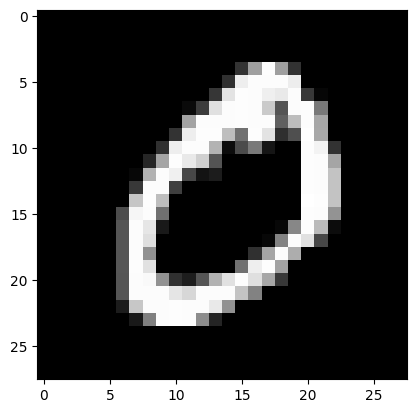

In [73]:
plt.imshow(train_data.data[1], cmap='gray')

In [6]:
train_data.data.float().std()

tensor(78.5675)

Next, we want to *normalize* our data. This means we want it to have a mean of zero and a standard deviation of one. 

Why do we want to do this? Normalizing our data allows our models to train faster and to also help them avoid local minima, i.e. train more reliably.

We normalize our data by subtracting the mean and dividing by the standard deviation of our dataset. First, we need to calculate the mean and standard deviation. **Note**: it is important that the mean and standard deviation are only calculated over the training set and not the test set. We do not want to use any information at all from the test set and should only look at it when we are calculating our test loss.

To calculate the means and standard deviations we get the actual data (the images) using the `.data.` attribute of our training data, convert them into floating point numbers, and then use the built-in `mean` and `std` functions to calculate the mean and standard deviation, respectively. The image data has values between 0-255, which we want to scale between 0-1, so we divide by 255.

In [75]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [76]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


Now we've calculated our mean and standard deviation how do we actually use them? We use Torchvision's `transforms`. 

A `transform` states how our data should be augmented and processed. Data augmentation involves manipulating the available training data in a way that artificially creates more training examples. We use `transforms.Compose` to built a list of transformations that will be applied to the image. 

The transforms we use are:
- `RandomRotation` - randomly rotates the image between `(-x, +x)` degrees, where we have set `x = 5`. Note, the `fill=(0,)` is due to a [bug](https://github.com/pytorch/vision/issues/1759) in some versions of torchvision. 
- `RandomCrop` - this first adds `padding` around our image, 2 pixels here, to artificially make it bigger, before taking a random `28x28` square crop of the image.
- `ToTensor()` - this converts the image from a PIL image into a PyTorch tensor.
- `Normalize` - this subtracts the mean and divides by the standard deviations given. 

The first two transformations have to be applied before `ToTensor` as they should both be applied on a PIL image. `Normalize` should only be applied to the images after they have been converted into a tensor. See the Torchvision documentation for [transforms that should be applied to PIL images](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-only) and [transforms that should be applied on tensors](https://pytorch.org/vision/stable/transforms.html#transforms-on-torch-tensor-only).

We have two lists of transforms, a train and a test transform. The train transforms are to artificially create more examples for our model to train on. We do not augment our test data in the same way, as we want a consistent set of examples to evaluate our final model on. The test data, however, should still be normalized.

In [77]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

print(train_transforms)
print(test_transforms)

Compose(
    RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=(0,))
    RandomCrop(size=(28, 28), padding=2)
    ToTensor()
    Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
)
Compose(
    ToTensor()
    Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
)


Now we have defined our transforms we can then load the train and test data with the relevant transforms defined.

In [78]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms
)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms
)

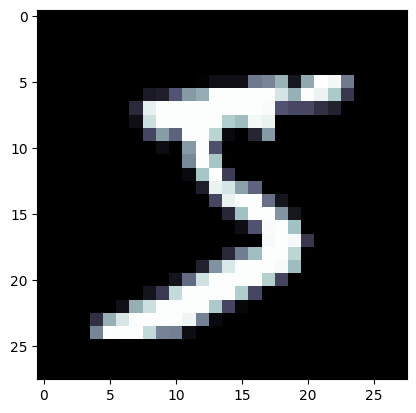

In [79]:
plt.imshow(train_data.data[0], cmap="bone")

We can simply check the `len` of the datasets to see how many examples are within each.

In [80]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


We can get a look at some of the images within our dataset to see what we're working with. The function below plots a square grid of images. If you supply less than a complete square number of images it will ignore the last few.

In [81]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

Let's load 25 images. These will have been processed through our transforms, so will be randomly rotated and cropped.

It's a good practice to see your data with your transforms applied, so you can ensure they look sensible. For example, it wouldn't make sense to flip the digits horizontally or vertically unless you are expecting to see what in your test data.

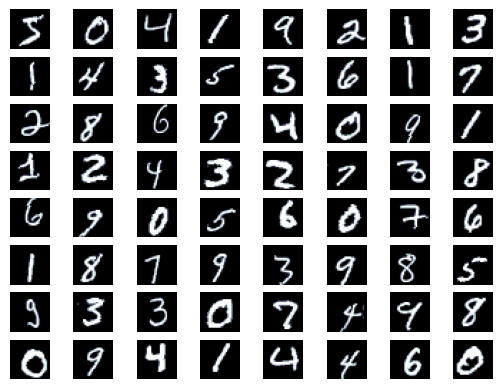

In [82]:
N_IMAGES = 64

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

The MNIST dataset comes with a training and test set, but not a validation set. We want to use a validation set to check how well our model performs on unseen data. Why don't we just use the test data? We should only be measuring our performance over the test set once, after all training is done. We can think of the validation set as a proxy test set we are allowed to look at as much as we want. 

Furthermore, we create a validation set, taking 10% of the training set. **Note:** the validation set should always be created from the training set. Never take the validation set from the test set. When researchers publish research papers they should be comparing performance across the test set and the only way to ensure this is a fair comparison is for all researchers to use the same test set. If the validation set is taken from the test set, then the test set is not the same as everyone else's and the results cannot be compared against each other.

First, we have to define the exact number of examples that we want to be in each split of the training/validation sets.

In [86]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
n_train_examples, n_valid_examples

(48600, 5400)

Then, we use the `random_split` function to take a random 10% of the training set to use as a validation set. The remaining 90% will stay as the training set.

In [87]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

We can print out the number of examples again to check our splits are correct.

In [88]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 48600
Number of validation examples: 5400
Number of testing examples: 10000


One thing to consider is that as the validation set has been created from the training set it has the same transforms as the training set, with the random rotating and cropping. As we want our validation set to act as a proxy for the test set, it should also be fixed, without any random augmentation. 

First, let's see what 25 of the images within the validation set look like with the training transforms:

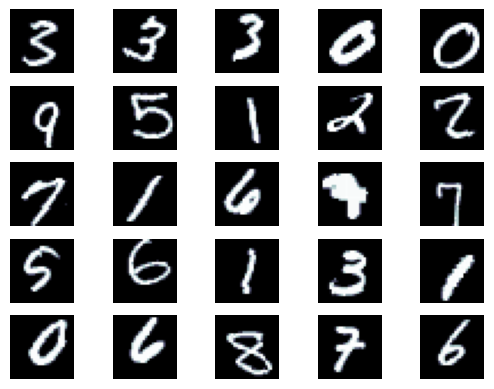

In [89]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

We can now simply replace the validation set's transform by overwriting it with our test transforms from above.

As the validation set is a `Subset` of the training set, if we change the transforms of one, then by default Torchvision will change the transforms of the other. To stop this from happening, we make a `deepcopy` of the validation data.

In [90]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

To double check we've correctly replaced the training transforms, we can view the same set of images and notice how they're more central (no random cropping) and have a more standard orientation (no random rotations).

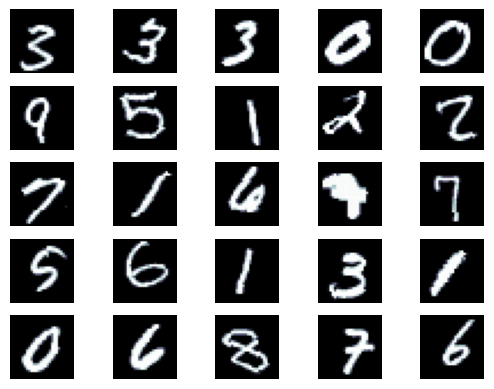

In [91]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

Next, we'll define a `DataLoader` for each of the training/validation/test sets. We can iterate over these, and they will yield batches of images and labels which we can use to train our model.

We only need to shuffle our training set as it will be used for stochastic gradient descent, and we want each batch to be different between epochs. As we aren't using the validation or test sets to update our model parameters, they do not need to be shuffled.

Ideally, we want to use the biggest batch size that we can. The 64 here is relatively small and can be increased if our hardware can handle it.

In [113]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining the Model

Our model will be a neural network, specifically a multilayer perceptron (MLP) with two hidden layers. The image below shows the archicture of the model. 

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)

Specifically, first we will flatten our 1x28x28 (1 color channel, 28 pixels height and width) image into a 784 element vector, also called 784 *features*. We flatten our input, as MLPs cannot handle two or three-dimensional data. Next, the 784 dimensional input is passed through the first hidden layer to transform it into 250 dimensions. Then, another hidden layer, which will transform it to 100 dimensions. Finally, an output layer which will transform it into a 10 dimensional vector. The output dimension should equal the number of classes within your data. Here we have ten digits, 0 - 9, so need our output to be 10 dimensions.

The transformation between 784 to 250, 250 to 100 and 100 to 10 dimensions are done by `Linear` layers. These are also known as fully connected or affine layers. In these layers, every element in one layer is connected to every element in the next. We can think of these elements as *neurons*, as this architecture is inspired by how the human brain is made of millions of interconnected nodes, also called neurons. 

Each connection between a neuron in one layer and a neuron in the next has a *weight* associated with it. The input to one neuron is the sum of the weighted values of all neurons in the previous layer connected to it, plus a weighted bias term, where the bias value is always 1. The neuron then applies an *activation function* to this weighted sum. This activation function is a non-linear function that allows the neural network to learn non-linear functions between inputs and outputs. 

We define our MLP below, which consists of three linear layers. We first take the input batch of images and flatten them, so they can be passed into the linear layers. We then pass them through the first linear layer, `input_fc`, which calculates the weighted sum of the inputs, and then apply the *ReLU* (rectified linear unit) activation function elementwise. This result is then passed through another linear layer, `hidden_fc`, again applying the same activation function elementwise. Finally, we pass this through the final linear layer, `output_fc`. We return not only the output but also the second hidden layer as we will do some analysis on it later.

The ReLU activation function is a popular non-linear function that is simply $max(0, x)$, where $x$ is the weighted sum of the inputs to that neuron. Other activation functions used are hyperbolic tan (tanh) and sigmoid function, however ReLU is the most commonly used.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/relu.png?raw=1)


One thing to note is that we do not use an activation function on the input directly or on the output. You should never use activation functions directly on the input, i.e. `F.relu(x)`. PyTorch combines activation functions to be applied on the output with the functions which calculate the *loss*, also known as *error* or *cost*, of a neural network. This is done for numerical stability.

Why did we choose hidden dimensions of 250 and 100 elements? Why did we only have two hidden layers? There is no magic formula to tell us how many layers to use and how many neurons to have in each layer, and there is most probably a better set of values. However, the general idea is that neural networks extract features from data. Layers closer to the input learn to extract general features (e.g. lines, curves, edges), whilst later layers combine the features extracted from the previous layer into more high level features (e.g. the intersection of two lines making a cross, multiple curves make a circle). We force our neural network to learn these features by reducing the number of neurons in each layer. This way, it has to learn to compress information by extracting only the useful and general features. Thus, we want a neural network with multiple layers and some sort of information compression (reduced number of neurons in subsequent layers).

In [92]:
class MLP(nn.Module): # Multi-Layered-Perceptron a.k.a Feed-Forward-Network
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_layer = nn.Linear(input_dim, 350)
        self.fc1 = nn.Linear(350, 170)
        self.fc2 = nn.Linear(170, 100)
        self.output_layer = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)  # x = [batch_size, height*width]

        x = F.relu(self.input_layer(x))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # h_2 = [batch size, 100]

        y_pred = self.output_layer(x)

        # y_pred = [batch size, output dim]

        return y_pred, x

We'll define our model by creating an instance of it and setting the correct input and output dimensions.

In [94]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

We can also create a small function to calculate the number of trainable parameters (weights and biases) in our model - in case all of our parameters are trainable.

In [96]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

The first layer has 784 neurons connected to 250 neurons, so 784*250 weighted connections plus 250 bias terms.

The second layer has 250 neurons connected to 100 neurons, 250*100 weighted connections plus 100 bias terms.

The third layer has 100 neurons connected to 10 neurons, 100*10 weighted connections plus 10 bias terms.

$$784 \cdot 250 + 250 + 250 \cdot 100 + 100 + 100 \cdot 10 + 10 = 222,360 $$

In [97]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 352,530 trainable parameters


### Training the Model

Next, we'll define our optimizer. This is the algorithm we will use to update the parameters of our model with respect to the loss calculated on the data.

We aren't going to go into too much detail on how neural networks are trained (see [this](http://neuralnetworksanddeeplearning.com/) article if you want to know how) but the gist is:
- pass a batch of data through your model
- calculate the loss of your batch by comparing your model's predictions against the actual labels
- calculate the gradient of each of your parameters with respect to the loss
- update each of your parameters by subtracting their gradient multiplied by a small *learning rate* parameter

We use the *Adam* algorithm with the default parameters to update our model. Improved results could be obtained by searching over different optimizers and learning rates, however default Adam is usually a good starting off point. Check out [this](https://ruder.io/optimizing-gradient-descent/) article if you want to learn more about the different optimization algorithms commonly used for neural networks.

In [103]:
p = next(model.parameters())
p.shape

torch.Size([350, 784])

In [98]:
optimizer = optim.Adam(model.parameters())

Then, we define a *criterion*, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual labels and then compute the loss/cost/error of your model with its current parameters.

`CrossEntropyLoss` both computes the *softmax* activation function on the supplied predictions as well as the actual loss via *negative log likelihood*. 

Briefly, the softmax function is:

$$\text{softmax}(\mathbf{x}) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

This turns out 10 dimensional output, where each element is an unbounded real number, into a probability distribution over 10 elements. That is, all values are between 0 and 1, and together they all sum to 1. 

Why do we turn things into a probability distribution? So we can use negative log likelihood for our loss function, as it expects probabilities. PyTorch calculates negative log likelihood for a single example via:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, y) = -\log \big( \text{softmax}(\mathbf{\hat{y}})[y] \big)$$

$\mathbf{\hat{y}}$ is the $\mathbb{R}^{10}$ output, from our neural network, whereas $y$ is the label, an integer representing the class. The loss is the negative log of the class index of the softmax. For example:

$$\mathbf{\hat{y}} = [5,1,1,1,1,1,1,1,1,1]$$

$$\text{softmax }(\mathbf{\hat{y}}) = [0.8585, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157]$$

If the label was class zero, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 0) = - \log(0.8585) = 0.153 \dots$$

If the label was class five, the loss would be:

$$\text{negative log likelihood }(\mathbf{\hat{y}}, 5) = - \log(0.0157) = 4.154 \dots$$

So, intuitively, as your model's output corresponding to the correct class index increases, your loss decreases.

In [104]:
criterion = nn.CrossEntropyLoss()

We then define `device`. This is used to place your model and data on to a GPU, if you have one.

In [105]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')

We place our model and criterion on to the device by using the `.to` method.

In [106]:
model = model.to(device)
criterion = criterion.to(device)
print(model, criterion)

MLP(
  (input_layer): Linear(in_features=784, out_features=350, bias=True)
  (fc1): Linear(in_features=350, out_features=170, bias=True)
  (fc2): Linear(in_features=170, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
) CrossEntropyLoss()


Next, we'll define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [107]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

We finally define our training loop.

This will:
- put our model into `train` mode
- iterate over our dataloader, returning batches of (image, label)
- place the batch on to our GPU, if we have one
- clear the gradients calculated from the last batch
- pass our batch of images, `x`, through to model to get predictions, `y_pred`
- calculate the loss between our predictions and the actual labels
- calculate the accuracy between our predictions and the actual labels
- calculate the gradients of each parameter
- update the parameters by taking an optimizer step
- update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is good practice to get used to putting your model in training mode.

In [115]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. As our model will not have to calculate gradients, it will be faster and use less memory. 

In [116]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The final step before training is to define a small function to tell us how long an epoch took.

In [111]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

In [117]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.423 | Train Acc: 86.50%
	 Val. Loss: 0.204 |  Val. Acc: 93.46%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.176 | Train Acc: 94.54%
	 Val. Loss: 0.150 |  Val. Acc: 95.44%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.144 | Train Acc: 95.49%
	 Val. Loss: 0.128 |  Val. Acc: 96.31%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.122 | Train Acc: 96.14%
	 Val. Loss: 0.124 |  Val. Acc: 96.47%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.115 | Train Acc: 96.54%
	 Val. Loss: 0.110 |  Val. Acc: 96.64%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.101 | Train Acc: 96.81%
	 Val. Loss: 0.101 |  Val. Acc: 96.91%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.093 | Train Acc: 97.10%
	 Val. Loss: 0.106 |  Val. Acc: 96.81%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.090 | Train Acc: 97.17%
	 Val. Loss: 0.099 |  Val. Acc: 96.99%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.084 | Train Acc: 97.41%
	 Val. Loss: 0.090 |  Val. Acc: 97.58%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 5s
	Train Loss: 0.079 | Train Acc: 97.51%
	 Val. Loss: 0.094 |  Val. Acc: 97.23%


Afterwards, we load our the parameters of the model that achieved the best validation loss and then use this to evaluate our model on the test set.

In [118]:
model.load_state_dict(torch.load('tut1-model.pt', weights_only=True))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Our model achieves 98% accuracy on the test set.

This can be improved by tweaking hyperparameters, e.g. number of layers, number of neurons per layer, optimization algorithm used, learning rate, etc. 

In [119]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.054 | Test Acc: 98.32%


### Examining the Model

Now we've trained our model, there are a few things we can look at. Most of these are simple exploratory analysis, but they can offer some insights into your model.

An important thing to do is check what examples your model gets wrong and ensure that they're reasonable mistakes.

The function below will return the model's predictions over a given dataset. It will return the inputs (image) the outputs (model predictions) and the ground truth labels.

In [120]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

We can then get these predictions and, by taking the index of the highest predicted probability, get the predicted labels.

In [121]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)
print(pred_labels)

tensor([7, 2, 1,  ..., 4, 5, 6])


Then, we can make a confusion matrix from our actual labels and our predicted labels.

In [123]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

The results seem reasonable enough, the most confused predictions-actuals are: 3-5 and 2-7.

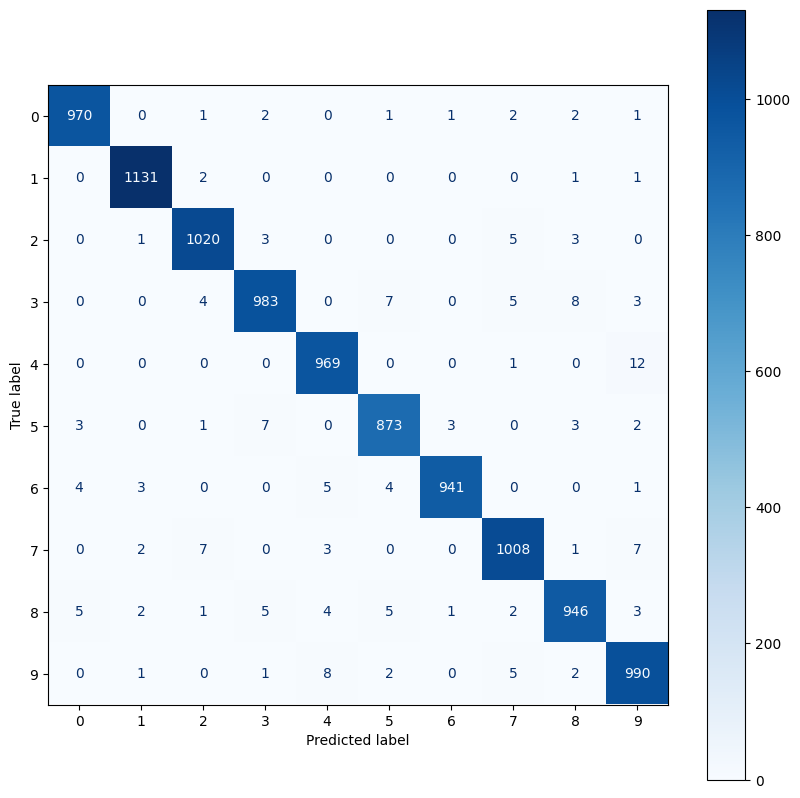

In [124]:
plot_confusion_matrix(labels, pred_labels)

Next, for each of our examples, we can check if our predicted label matches our actual label.

In [125]:
corrects = torch.eq(labels, pred_labels)

We can then loop through all of the examples over our model's predictions and store all the examples the model got incorrect into an array.

Then, we sort these incorrect examples by how confident they were, with the most confident being first.

In [126]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

We can then plot the incorrectly predicted images along with how confident they were on the actual label and how confident they were at the incorrect label.

In [127]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

Below we can see the 25 images the model got incorrect and was most confident about.

A lot of these digits are irregular, so it's difficult for the model to do well on these. The images that do look fine, if you squint you can sort of see why the model got it wrong.

Why is the neural network so confident on the irregular digits? Surely if it's a weird looking digit then the output of the softmax should be close to evenly distributed across a few digits the model isn't sure about, right? Well, no. The model has been trained to only be incredibly confident about its predictions, and thus when it sees an image it will always be confident about what it is.

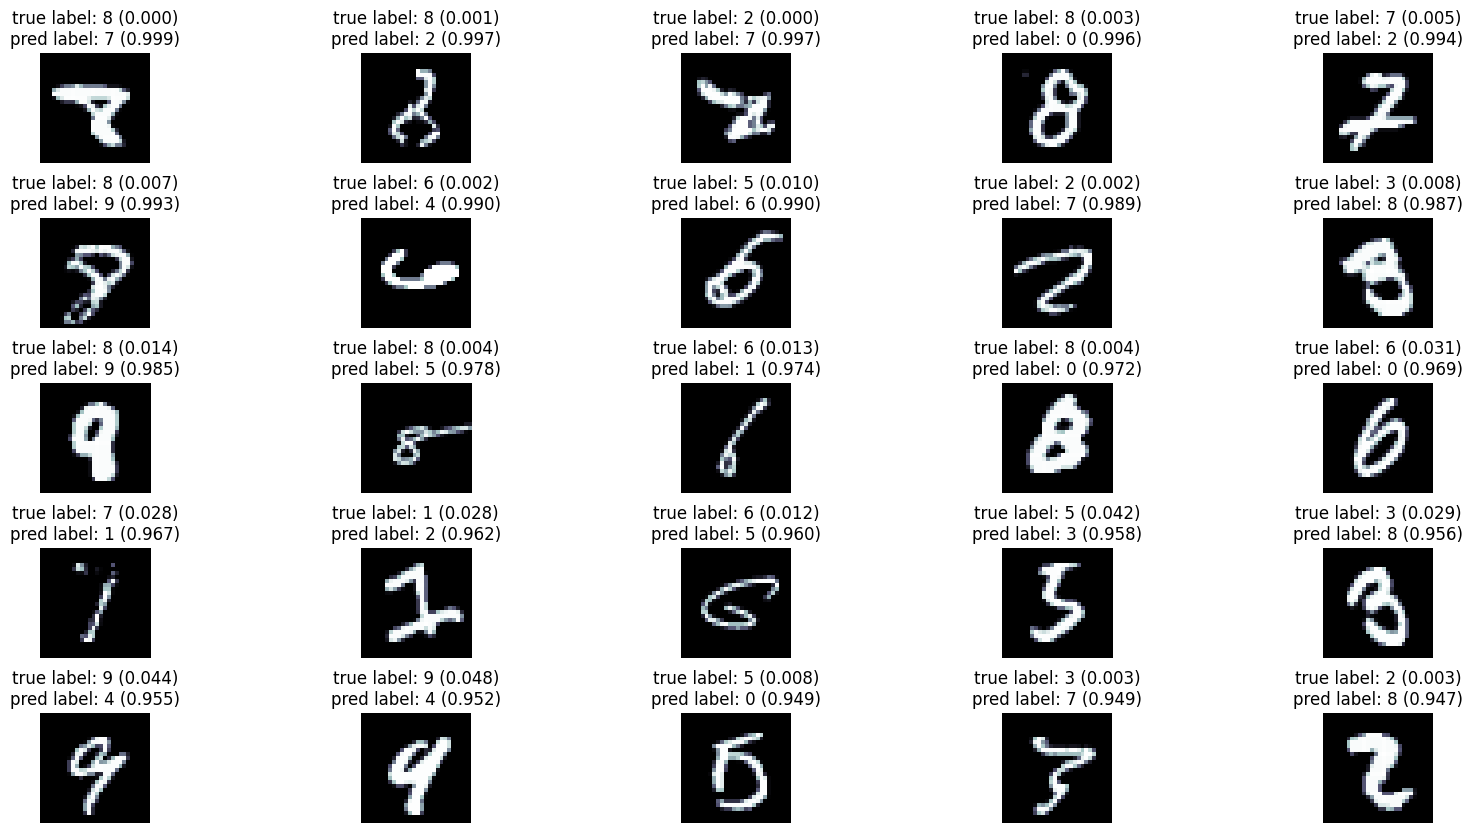

In [128]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Another thing we can do is get the output and intermediate representations from the model and try to visualize them.

The function below loops through the provided dataset and gets the output from the model and the intermediate representation from the layer before that, the second hidden layer.

In [129]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

We run the function to get the representations.

In [130]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/760 [00:00<?, ?it/s]

The data we want to visualize is in ten dimensions and 100 dimensions. We want to get this down to two dimensions, so we can actually plot it. 

The first technique we'll use is PCA (principal component analysis). First, we'll define a function to calculate the PCA of our data, and then we'll define a function to plot it.

In [131]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [133]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

First, we plot the representations from the ten dimensional output layer, reduced down to two dimensions.

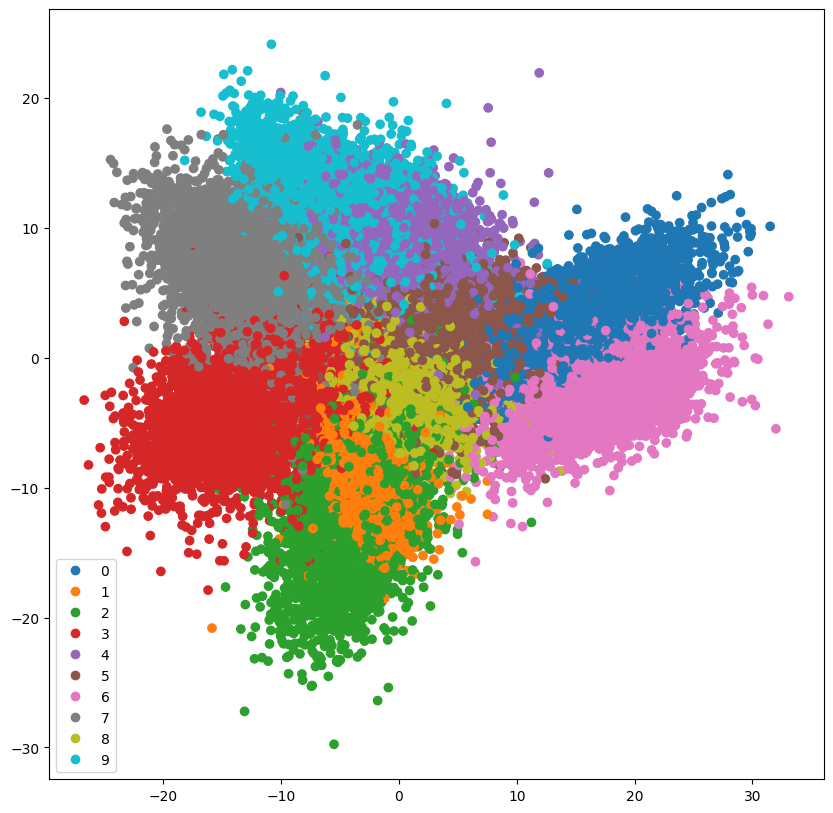

In [134]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

Next, we'll plot the outputs of the second hidden layer. 

The clusters seem similar to the one above. In fact if we rotated the below image anti-clockwise it wouldn't be too far off the PCA of the output representations.

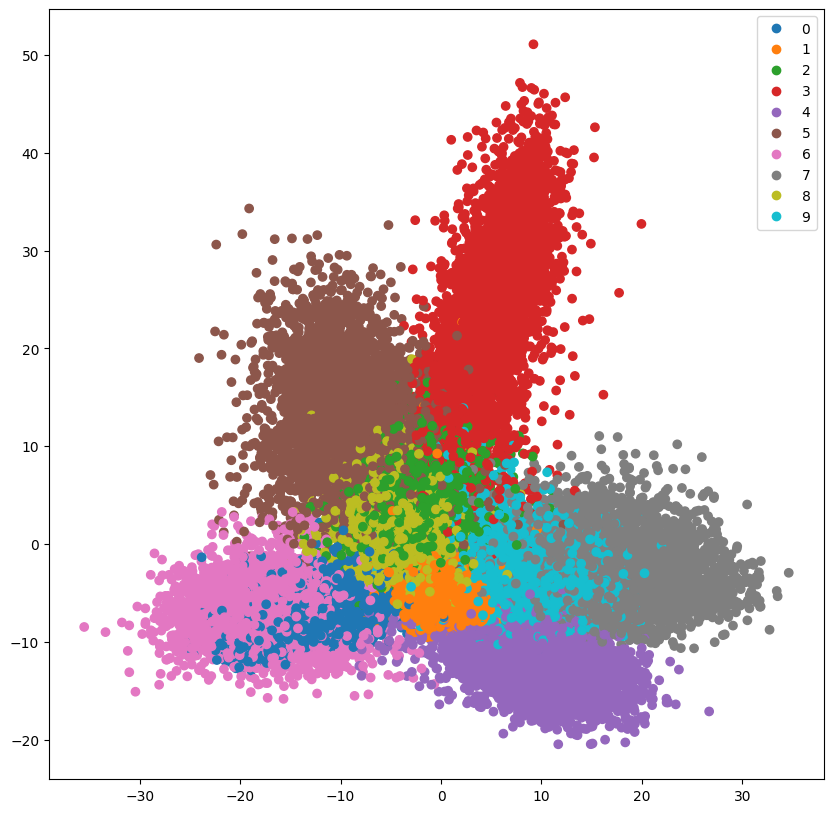

In [135]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

An alternative to PCA is t-SNE (t-distributed stochastic neighbor embedding). 

This is commonly thought of as being "better" than PCA, although it can be [misinterpreted](https://distill.pub/2016/misread-tsne/).

In [136]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

t-SNE is very slow, so we only compute it on a subset of the representations.

The classes look very well separated, and it is possible to use [k-NN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) on this representation to achieve decent accuracy.

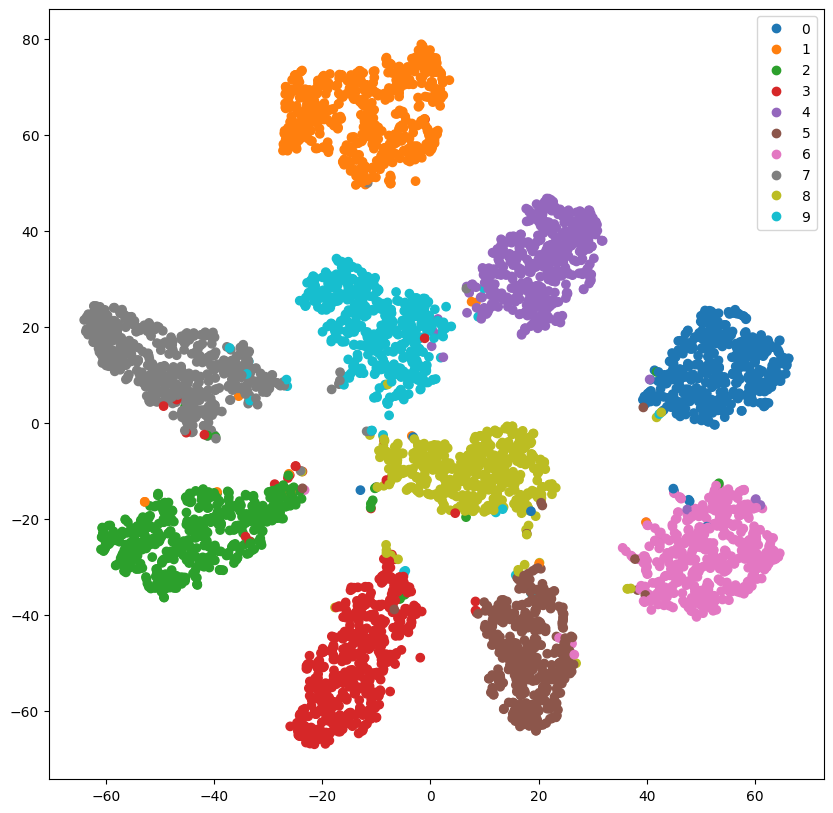

In [91]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

We plot the intermediate representations on the same subset.

Again, the classes look well separated, though less so than the output representations. This is because these representations are intermediate features that the neural network has extracted and will use them in further layers to weigh up the evidence of what digit is in the image. Hence, in theory, the classes should become more separated the closer we are to the output layer, which is exactly what we see here.

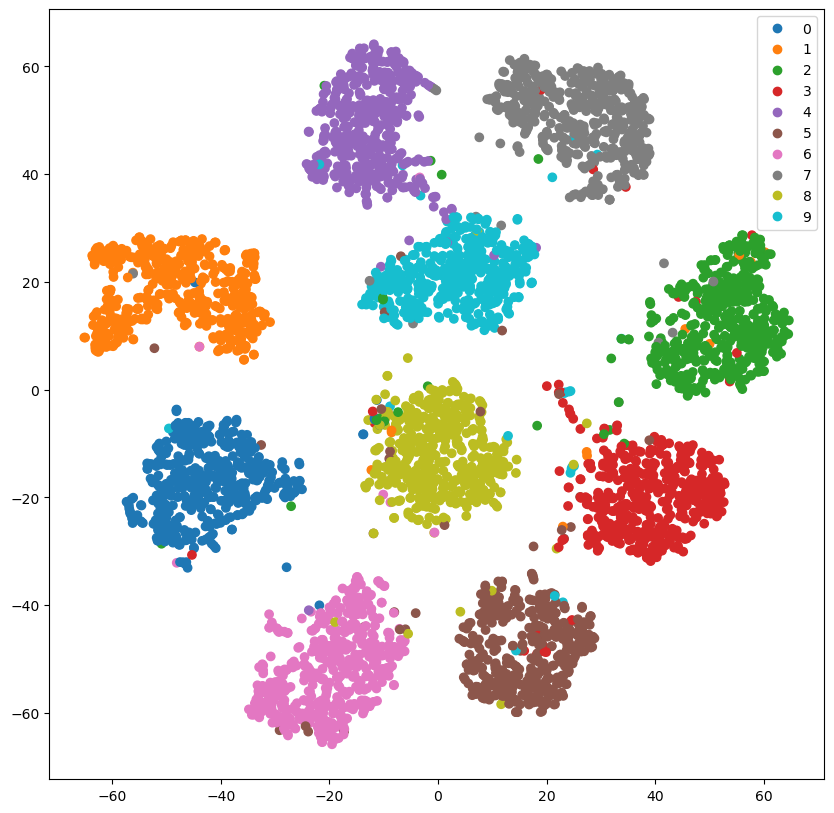

In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

Another experiment we can do is try and generate fake digits. 

The function below will repeatedly generate random noise and feed it through the model and find the most confidently generated digit for the desired class.

In [137]:
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

Let's try and generate a perfect three.

In [138]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

Looking at the best probability achieved, we have a digit that the model is 100% confident is a three. 

In [139]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 99.98%


Unfortunately, the imagined perfect three just looks like random noise.

As mentioned before, the model has only been trained to be incredibly confident with its predictions, so when faced with random noise will try and classify it as something. 

It is also possible that the model is *overfitting* on the training set - that there is a common pattern in handwritten threes within the training set, but it's not the pattern we want our model to learn.

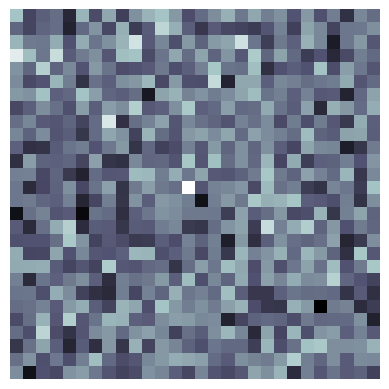

In [140]:
plt.imshow(best_image.cpu().numpy(), cmap='bone')
plt.axis('off');

Finally, we can plot the weights in the first layer of our model. 

The hope is that there's maybe one neuron in this first layer that's learned to look for certain patterns in the input and thus has high weight values indicating this pattern. If we then plot these weights, we should see these patterns.

In [142]:
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

Looking at these weights we see a few of them look like random noise but some of them do have weird patterns within them. These patterns show "ghostly" image looking shapes, but are clearly not images.

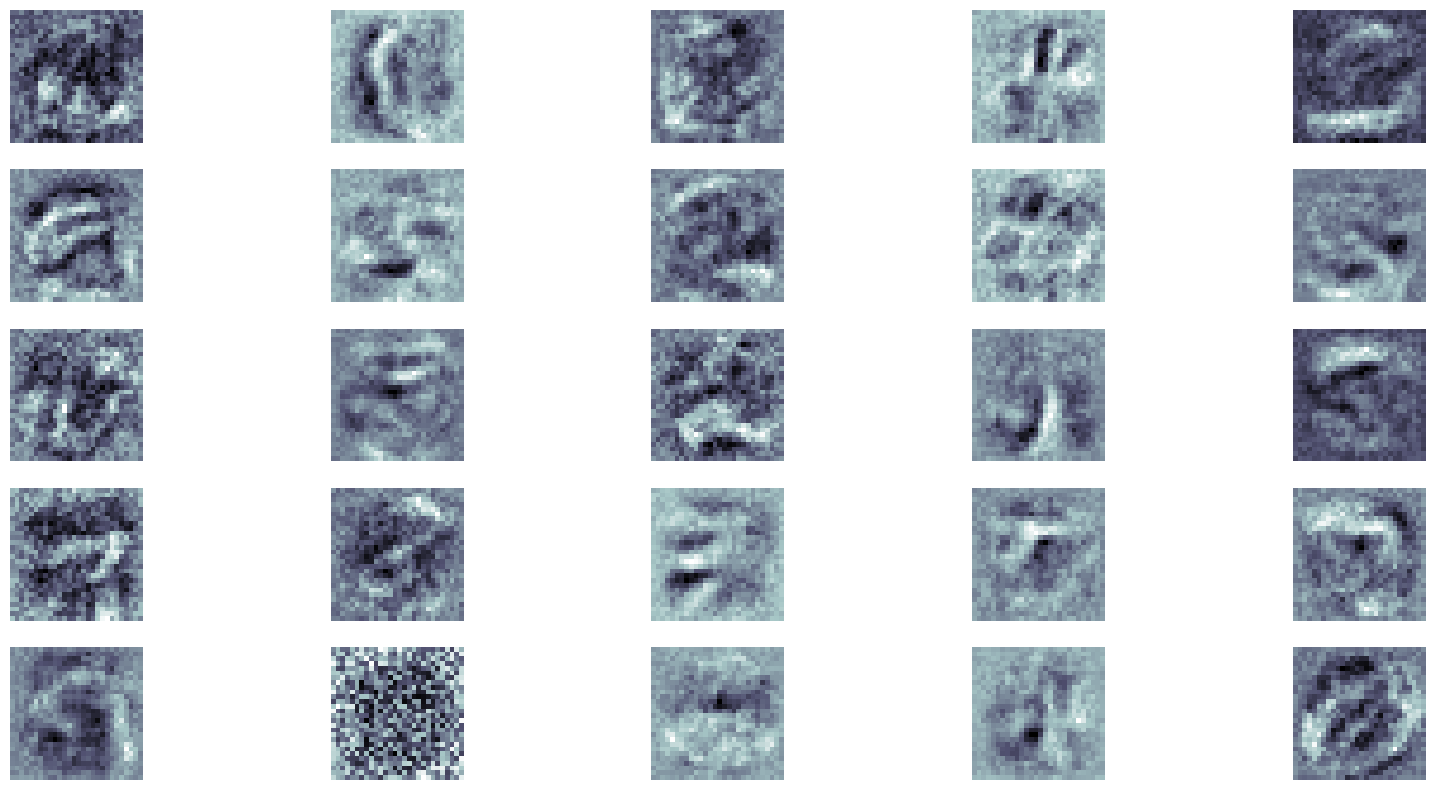

In [143]:
N_WEIGHTS = 25

weights = model.input_layer.weight.data

plot_weights(weights, N_WEIGHTS)

#### Convolutional Neural Networks (CNNs)

A Convolutional Neural Network (CNN) is a type of artificial neural network that excels in processing grid-like data, such as images, by using convolutional layers to extract and transform features. These networks learn hierarchical representations of data, allowing higher layers to recognize more complex patterns and features than lower layers. 

Key aspects of CNNs:
  - **Convolutional Layers**: These layers apply filters (kernels) to the input data, which are often images, to extract features like edges, shapes, and textures. 
  - **Pooling Layers**: These layers reduce the spatial dimensions of the feature maps, making the network less sensitive to small variations in the input. 
  - **Hierarchical Feature Learning**: CNNs learn features in a hierarchical manner, with lower layers learning basic features and higher layers combining these to recognize more complex patterns. 
  - **Applications**: CNNs are widely used in various fields, including image recognition, object detection, natural language processing, and more. 

#### Earliest CNN - LeNet-5

LeNet-5 was developed in the late 1990s by Yann LeCun, Leon Bottou, and others - as a neural network architecture for recognizing hand-written and machine-printed characters (mainly digits). It is still being used in banking systems for recognising handwritten digits on cheque leafs.

The image below shows the architecture of LeNet-5. It consists of two convolutional layers, each followed by a subsampling layer, and then three fully connected linear layers.

![image](./lenet5.png)


In [144]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [145]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

### Defining the Model

The LeNet architectures, and almost every modern neural network computer vision architecture, makes use of convolutional neural network (CNN) layers. 

So, what is a CNN layer? Each convolutional layer has a number of *filters*, also commonly referred to as *kernels*. A filter is a (usually) square matrix that slides across the pixels in an image from left-to-right, top-to-bottom. At each "step", the filter performs a [convolution](https://en.wikipedia.org/wiki/Convolution) operation on the image. The output of the convolutional layer is the result of these convolutions after the filter's final "step". 

**Note:** in machine learning frameworks there aren't actually "steps", the result for every filter location is calculated at the same time, in parallel. This is a lot faster than actually stepping through the image, but thinking about it in terms of steps makes everything easier to visualize.

Let's have a look at a single 2x2 filter passing over an image. We'll pretend the image is 10x10 pixels in this example.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/filter-mnist.png?raw=1)

The filter (red) slides over the pixels of the image, stepping one pixel at a time. The size of the steps is called the *stride*, and we use a stride of one in this implementation, which means the filter moves one pixel at a time horizontally and moves one pixel down once it reaches the end of a row. The result of the convolution operation (green) is a pixel in the filtered image. All of these convolutions produce a new, filtered image.

Notice how the image coming out of the CNN layer is smaller than the image coming into the CNN. This is because the 2x2 filter has only nine steps horizontally and vertically. If we wanted to keep the output image the same size as the input image, we could add padding - usually black pixels - around our image. 

When we have no padding and a step size of one, the size of the output image is: 

$$\text{height}_{\text{out}} = \text{height}_{\text{in}} - \text{filter}_{\text{height}} + 1$$

$$\text{width}_{\text{out}} = \text{width}_{\text{in}} - \text{filter}_{\text{width}} + 1$$

How do we calculate the values of the output pixels using the filter? It's simply multiplying and adding! Each of the input image pixels covered by a filter is multiplied by the filter's weight over that pixel. All of these products are then summed together to get the value of the pixel in the output image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-filter.png?raw=1)

The same weights are used by the filter over the whole image. The weights do not change depending on the filter's location within the image. One nice thing about this is that the filters (and the convolutional layers themselves) are *translation invariant*, that means it doesn't matter where a feature (curve, edge, line) appears in an image, the convolutional layer will find all occurrences of it. 

The weights for the filters, much like the weights of the linear layers in multilayer perceptrons, are learned via gradient descent and backpropagation.

Why are convolutional neural networks structured in this way? Filters applied across an image in this way can be used to detect patterns such as horizontal and vertical lines within an image. These patterns can be thought of as features of the image, which our CNN extracts. These extracted features can then be combined in further layers of the neural network with other extracted features and together create higher level features, e.g. a certain position and orientation of two lines to make a cross, which can indicate the centre of a handwritten 4.

CNNs are also inspired by classic computer vision techniques, like [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator). Let's try manually choosing weights of a 3x3 filter to make Sobel filters and apply them to some MNIST digits to see what type of things our CNN layers can learn.

The `plot_filter` function takes in a batch of images and a two-dimensional filter and plots the output of that filter applied to all of the images.

In [146]:
def plot_filter(images, filter):

    images = torch.cat([i.unsqueeze(0) for i in images],
                                dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Filtered')
        ax.axis('off')

We'll then get a batch of images to test our handwritten Sobel filters on. We get the images from the test set, as they're easier to examine without the transforms applied to them.

In [147]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

The first filter is for detecting horizontal lines.

We can see on the filtered images that the highest values (the whitest pixels) of the filtered image are where there is a horizontal line that is black on top and white below, e.g. the top of the 7 digit. The lowest values (the blackest pixels) of the filtered image are where there is a horizontal line that goes from white to black, e.g. the bottoms of all the digits.

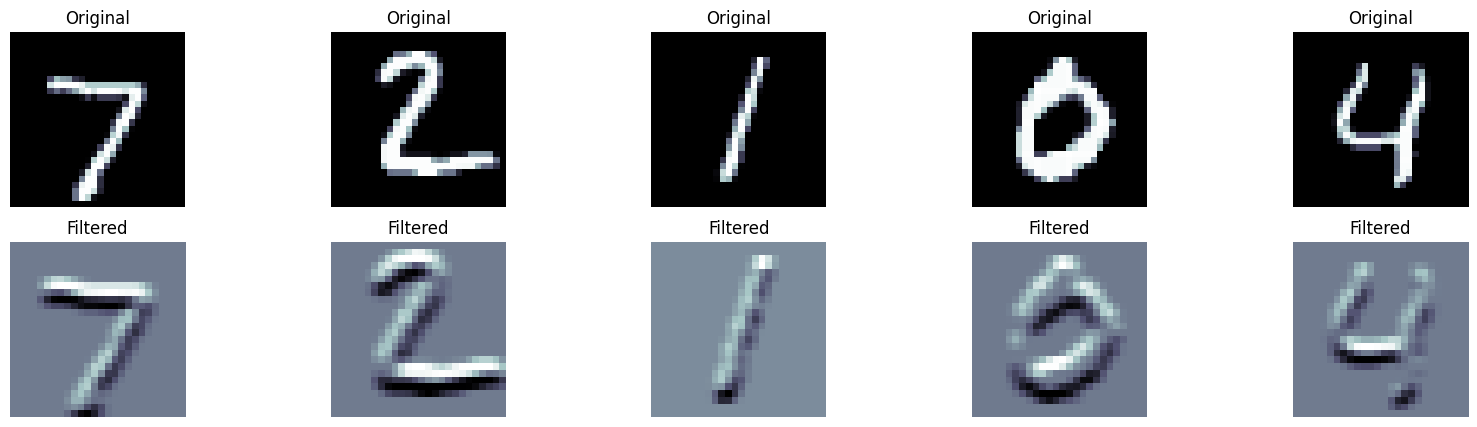

In [150]:
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

By swapping the first and last rows of the above filter, we get a filter that detects horizontal lines from white on top to black underneath.

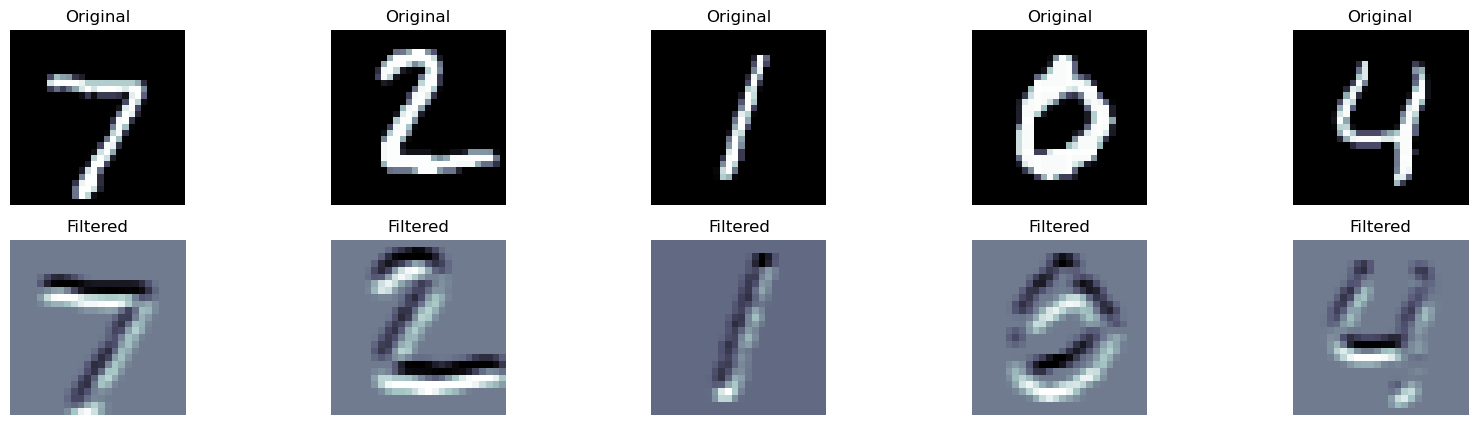

In [ ]:
horizontal_filter = [[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]]

plot_filter(images, horizontal_filter)

We can also design filters that detect vertical lines. 

Here's one that detects vertical lines that are black on the left and white on the right.

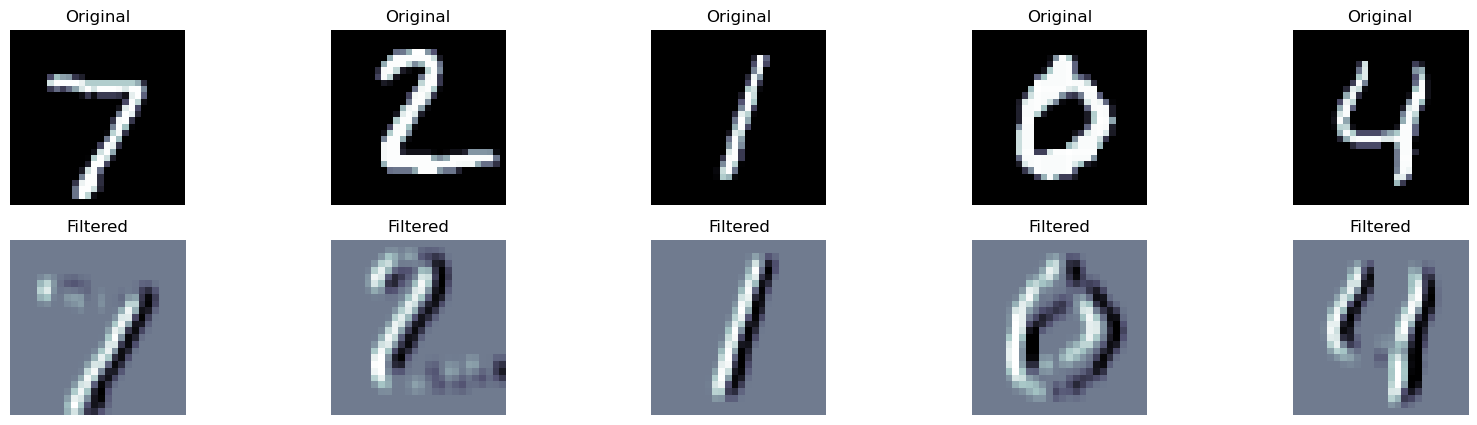

In [ ]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

To get the opposite filter, one that detects vertical lines that are white on the left and black on the right, we swap the left and right columns.

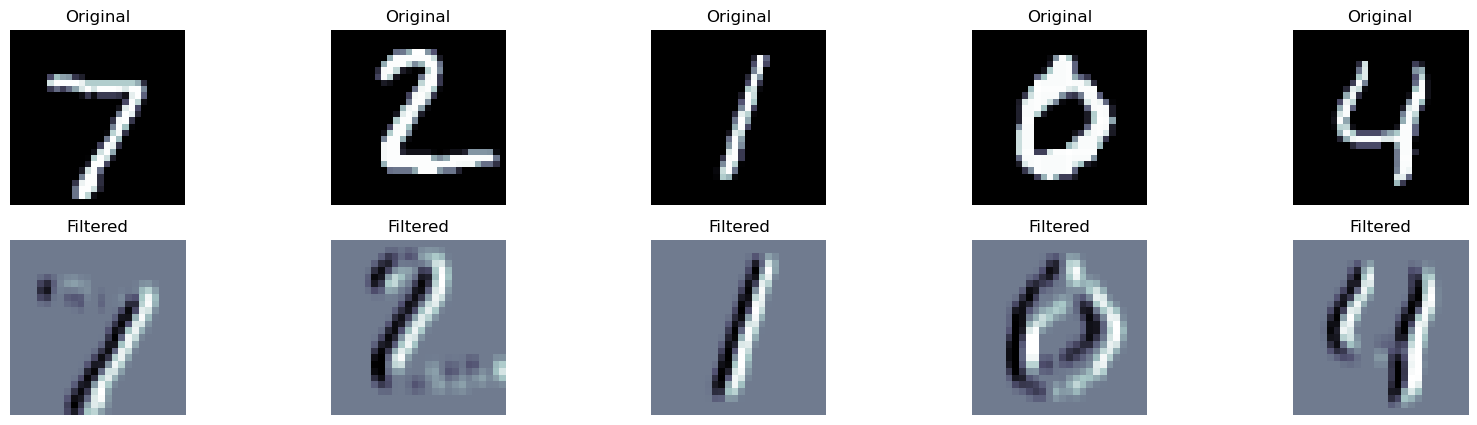

In [ ]:
vertical_filter = [[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]]

plot_filter(images, vertical_filter)

Finally, we'll design a diagonal detecting filter. This one detects lines pointing towards the top right of the image.

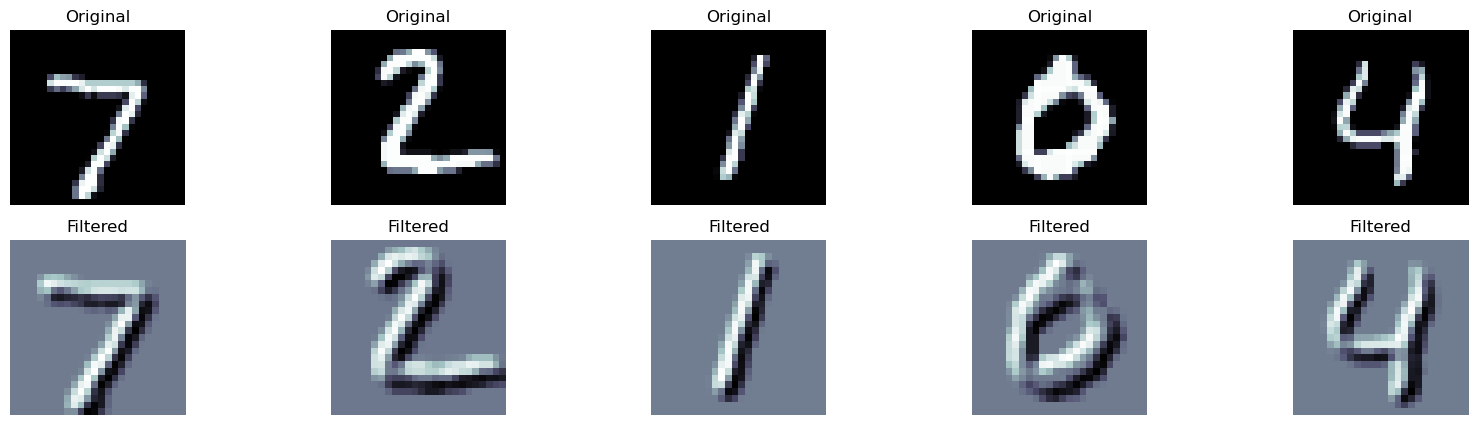

In [ ]:
diagonal_filter = [[-2, -1, 0],
                   [-1,  0, 1],
                   [ 0,  1, 2]]

plot_filter(images, diagonal_filter)

The great thing about convolutional layers is that each layer doesn't just have a single filter. It has as many filters as you want. Each filter has their own set of weights, so (in theory) is learning to extract different features. 

The image below shows what happens when we use a convolutional layer with five filters. The original image with a single color channel (as it's black and white) has five filters applied to it to get five filtered images. These images are then stacked together to get what we can think of as a single image with five channels.  

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-filter-mnist.png?raw=1)

What about when you now want to pass this five channel filtered image to another convolutional layer? Now, that convolutional layer won't just have a height and a width, but it will also have a depth equal to the number of channels in the input image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-channel-mnist.png?raw=1)

As you can see, the filter has a height, width and depth of 2x2x5. All the 20 pixel values covered by this filter are multiplied by the filter's weight and then summed. The result of this will have as many channels as there are filters, and a subsequent convolutional layer will have to have filters with a depth equal to that number of channels.

Hopefully that's enough on convolutional layers, but if not, then there are [plenty](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) of [other](https://cs231n.github.io/convolutional-networks/) resources [about](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) them [online](https://www.coursera.org/learn/convolutional-neural-networks).

Next, we'll talk about the subsampling layers. These are layers used to reduce the size/resolution of their input and are commonly applied to the output of convolutional layers. The most common two methods of subsampling are *max pooling* and *mean pooling* (also known as *average pooling*), and thus subsampling is often know as *pooling*.

Why do we want to reduce the resolution of the image? It speeds up our model, as convolution operations are expensive. If we subsample and half the size of our image before it passes into the next convolutional layer, that's a significant speed-up.

Subsampling layers aren't too different to convolutional layers. They have a filter with a size and a stride. However, pooling layers do not have any parameters - weights and biases. They simply perform an operation on the image. Max pooling returns the maximum of the values covered by the filter, and we can think of it as extracting the single most important feature under the filter. Mean/average pooling returns the mean/average of the values covered by the filter and we can think of it as equally weighting all features under the filter.

Let's look at a 2x2 pooling operation, with a stride of 2, over an image:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/subsample-mnist.png?raw=1)

Commonly, and by default in PyTorch, the stride for the height and the width is the height and the width of the filter and each pixel is only seen by the pooling layer once, thus:

$$\text{height}_{\text{out}} = \frac{\text{height}_\text{in}}{\text{filter}_{\text{height}}}$$

$$\text{width}_{\text{out}} = \frac{\text{width}_\text{in}}{\text{filter}_{\text{width}}}$$

For max pooling, the value of the output for each filter location is:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-pool.png?raw=1)

Let's create a function that allows us to see the outputs of a pooling layer on a batch of images.

In [151]:
def plot_subsample(images, pool_type, pool_size):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size=pool_size)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Subsampled')
        ax.axis('off')

First, let's see max pooling with a filter size of 2. 

We can see that the image is heavily downsampled - reduced in size/resolution and in quality.

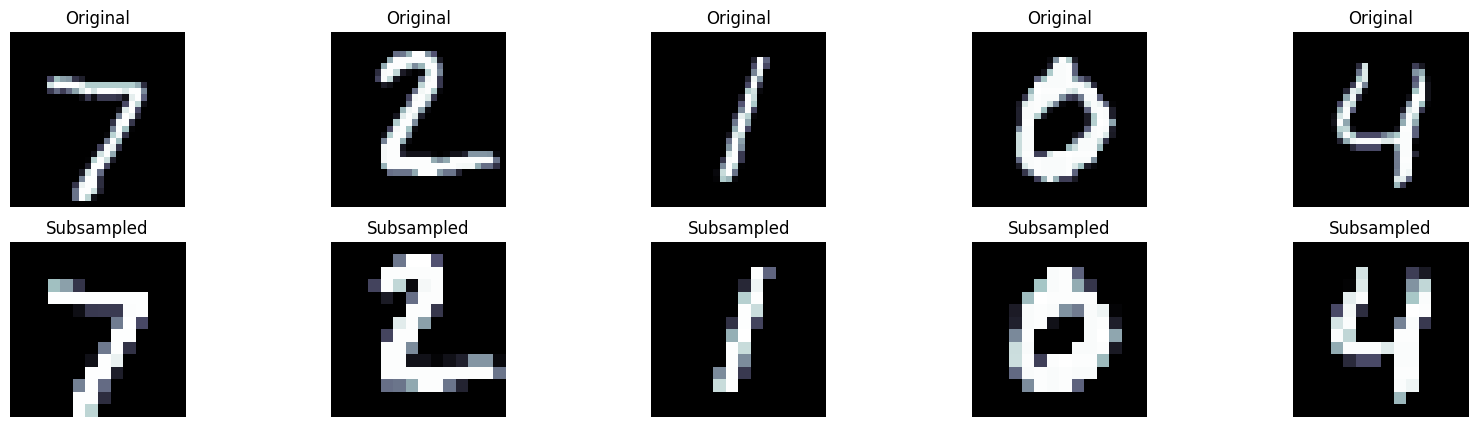

In [156]:
plot_subsample(images, 'max', 2)

If we increase the size of the max pooling filter, the images get smaller and the quality gets worse.

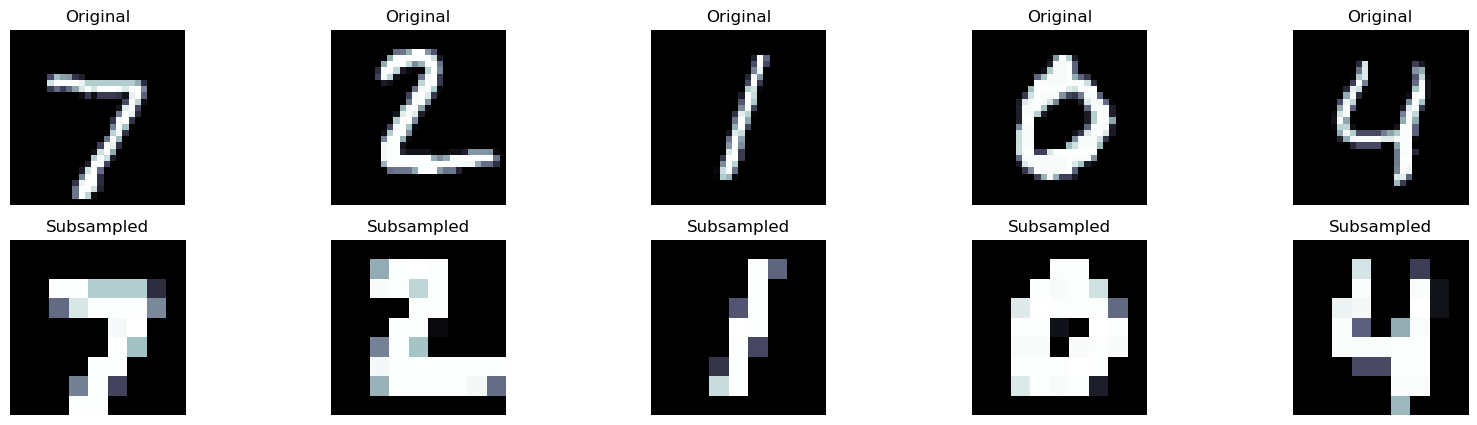

In [ ]:
plot_subsample(images, 'max', 3)

For average pooling, the same effect happens, however the loss in quality is not as harsh.

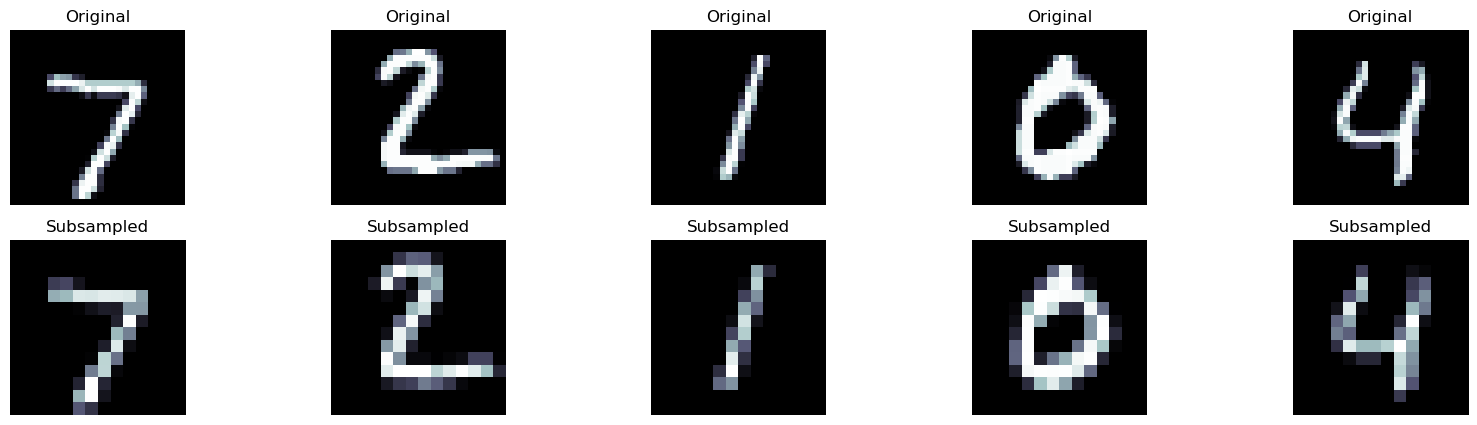

In [ ]:
plot_subsample(images, 'avg', 2)

Again, we can increase the filter size, reducing the resolution of the output image at the cost of image quality - however, the quality drop is not as bad as max pooling.

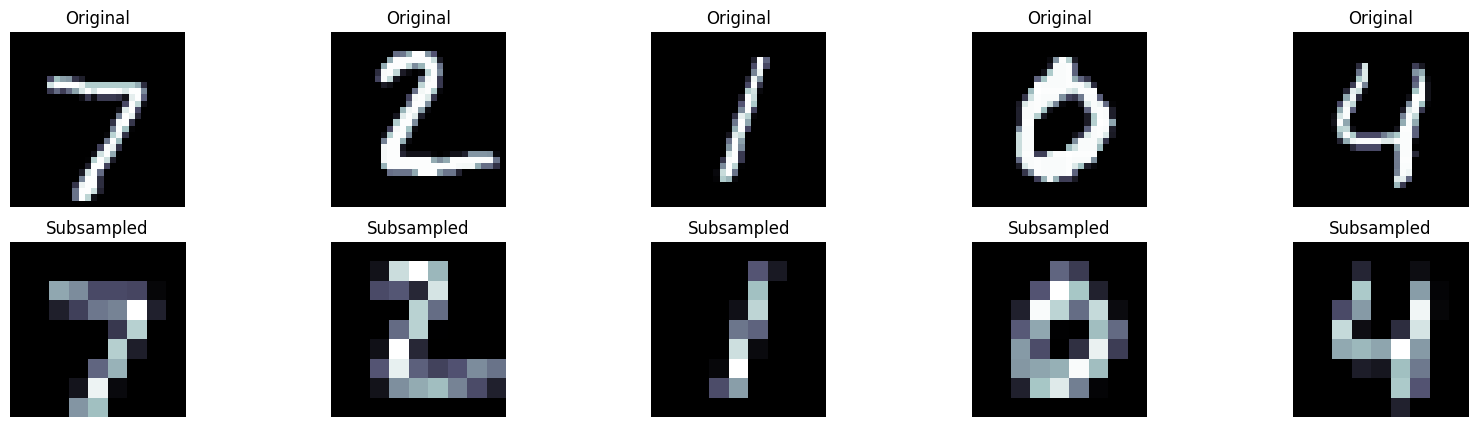

In [159]:
plot_subsample(images, 'avg', 3)

Similarly to convolutional layers, if the input image has more than one channel, the filter has a depth equal to the number of channels. Thus, if we did a max pool with a 5x5x6 filter (height and width of 5 and depth of 6), the output at each pixel would be the maximum value of all 150 pixels covered by the filter.

### Defining the Model

Now we've gone through all the concepts, we can implement our model.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Our actual implementation is going to slightly differ from the actual LeNet architecture, as it was built to handle 32x32 images, whereas the MNIST dataset consists of 28x28 images. We're also not going to use the Gaussian connections at the end, instead we'll just use a standard linear layer.

The first layer in our model is a convolutional layer with 6 filters (PyTorch calls them `out_channels`) and a kernel size of 5. This turns our `[1, 28, 28]` image into `[6, 24, 24]`. We then downsample our image with a max pooling layer that has a filter size of 2 to get a `[6, 12, 12]` image. This is then passed through an activation function, ReLU in this case, which is applied elementwise and does not change the of the image. 

Afterwards, we pass the image to the second convolutional layer with 16 filters that are 5x5x6, a height and width of 5 and a depth of 6 as our previous convolutional layer had 6 filters. This gives us an image size of `[16, 8, 8]` which we then max pool to half the height and width to `[16, 4, 4]` and then pass through another ReLU function.

We then flatten our `[16, 4, 4]` image to `[256]` and pass this through three linear layers. Each of the linear layers are followed by another ReLU, except for the last.

We return the results from the final linear layer as well as from the flattened result of the second convolutional layer, which we can plot in lower dimensions later.

Note that you should always apply your activation function **after** the pooling layer. You will get the exact same results if you apply the activation function before, however this means you will be applying your activation function to a larger number of inputs, increasing the computation required. Using the activation function after the image has been reduced in size means it will be applied to fewer inputs and thus use less computation.

In [161]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        # x = [batch size, 1, 28, 28]

        x = self.conv1(x)

        # x = [batch size, 6, 24, 24]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 6, 12, 12]

        x = F.relu(x)

        x = self.conv2(x)

        # x = [batch size, 16, 8, 8]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 16, 4, 4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)

        # x = [batch size, 16*4*4 = 256]

        h = x

        x = self.fc_1(x)

        # x = [batch size, 120]

        x = F.relu(x)

        x = self.fc_2(x)

        # x = batch size, 84]

        x = F.relu(x)

        x = self.fc_3(x)

        # x = [batch size, output dim]

        return x, h

In [162]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

...and calculate the number of parameters. 

Notice that this model has significantly fewer parameters than the previous model: 44,000 parameters compared to 222,000.

In [163]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,426 trainable parameters


### Training the Model

We define our optimizer...

In [164]:
optimizer = optim.Adam(model.parameters())

...our loss function (which will also apply the softmax activation function)...

In [165]:
criterion = nn.CrossEntropyLoss()

...define the device (to put our model and data on the GPU, if we have one)...

In [166]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')

...place the model and criterion on the device...

In [167]:
model = model.to(device)
criterion = criterion.to(device)

...define a function to calculate accuracy...

In [168]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...define a function that performs a training epoch...

In [169]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...define a function that performs an evaluation epoch...

In [170]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...define a function that tells us how long an epoch takes...

In [171]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

...and finally we can begin training!

Even though we have significantly fewer parameters, the model still takes around the same amount of time per epoch (convolutional layers are computationally expensive) and we train it a bit longer.

However, we beat the ~98% validation accuracy achieved by the multilayer perceptron model and achieve 99% validation accuracy.

In [172]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.408 | Train Acc: 86.99%
	 Val. Loss: 0.131 |  Val. Acc: 96.04%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.126 | Train Acc: 96.17%
	 Val. Loss: 0.108 |  Val. Acc: 96.49%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.094 | Train Acc: 97.06%
	 Val. Loss: 0.084 |  Val. Acc: 97.28%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.078 | Train Acc: 97.57%
	 Val. Loss: 0.068 |  Val. Acc: 97.86%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.068 | Train Acc: 97.92%
	 Val. Loss: 0.067 |  Val. Acc: 97.83%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.062 | Train Acc: 98.09%
	 Val. Loss: 0.082 |  Val. Acc: 97.63%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.057 | Train Acc: 98.23%
	 Val. Loss: 0.053 |  Val. Acc: 98.26%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.052 | Train Acc: 98.41%
	 Val. Loss: 0.064 |  Val. Acc: 98.07%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.050 | Train Acc: 98.43%
	 Val. Loss: 0.040 |  Val. Acc: 98.88%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 6s
	Train Loss: 0.047 | Train Acc: 98.59%
	 Val. Loss: 0.049 |  Val. Acc: 98.40%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 6s
	Train Loss: 0.046 | Train Acc: 98.52%
	 Val. Loss: 0.053 |  Val. Acc: 98.35%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 6s
	Train Loss: 0.042 | Train Acc: 98.69%
	 Val. Loss: 0.052 |  Val. Acc: 98.51%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 6s
	Train Loss: 0.041 | Train Acc: 98.69%
	 Val. Loss: 0.060 |  Val. Acc: 98.17%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 6s
	Train Loss: 0.041 | Train Acc: 98.69%
	 Val. Loss: 0.045 |  Val. Acc: 98.75%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 6s
	Train Loss: 0.038 | Train Acc: 98.79%
	 Val. Loss: 0.048 |  Val. Acc: 98.46%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 6s
	Train Loss: 0.037 | Train Acc: 98.82%
	 Val. Loss: 0.042 |  Val. Acc: 98.71%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 6s
	Train Loss: 0.035 | Train Acc: 98.88%
	 Val. Loss: 0.043 |  Val. Acc: 98.68%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 6s
	Train Loss: 0.034 | Train Acc: 98.94%
	 Val. Loss: 0.037 |  Val. Acc: 98.82%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 6s
	Train Loss: 0.035 | Train Acc: 98.88%
	 Val. Loss: 0.049 |  Val. Acc: 98.51%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 6s
	Train Loss: 0.031 | Train Acc: 98.97%
	 Val. Loss: 0.044 |  Val. Acc: 98.82%


We load the parameters which performed the best on the validation set and then evaluate our performance on the test set.

Just like the validation accuracy, we get 99% test accuracy!

In [173]:
model.load_state_dict(torch.load('tut2-model.pt', weights_only=True))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.025 | Test Acc: 99.23%


### Examining the Model

Much like the previous notebook, we'll examine our model by: plotting a confusion matrix, seeing which incorrect examples our model was most confident about, view our model's learned representations in two dimensions with PCA and t-SNE, and view the weights of our model.

First, we'll get the model's predictions across the test set...

In [174]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [175]:
images, labels, probs = get_predictions(model, test_iterator, device)

...and then get the predicted labels from the model's predictions.

In [176]:
pred_labels = torch.argmax(probs, 1)

Next, we'll plot the confusion matrix.

In [179]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

The only real problem the model seemed to have is predicting 2s as 7s.

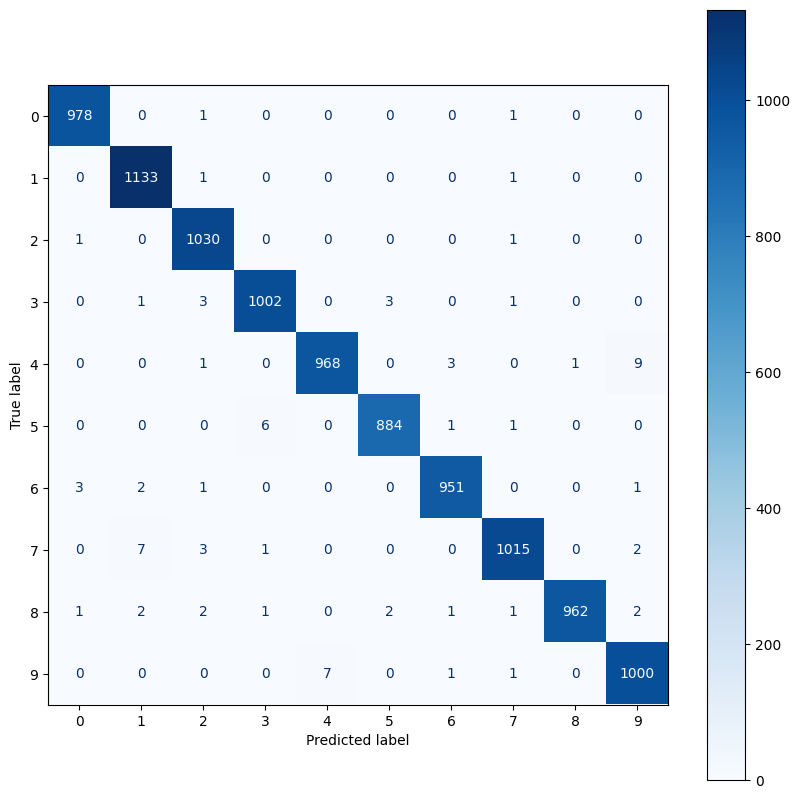

In [180]:
plot_confusion_matrix(labels, pred_labels)

Next, we'll find out which of our examples are correct...

In [ ]:
corrects = torch.eq(labels, pred_labels)

...then get all of the incorrect examples and sort them by descending confidence in their prediction.

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

We can then use this to plot the examples the model got wrong and was most confident about.

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

The mistakes look pretty reasonable. All the digits shown here are a bit off.

As mentioned in the previous notebook, the model is always trained to be incredibly confident with its predictions, so it's not unreasonable for it to be incredibly confident when it's wrong.

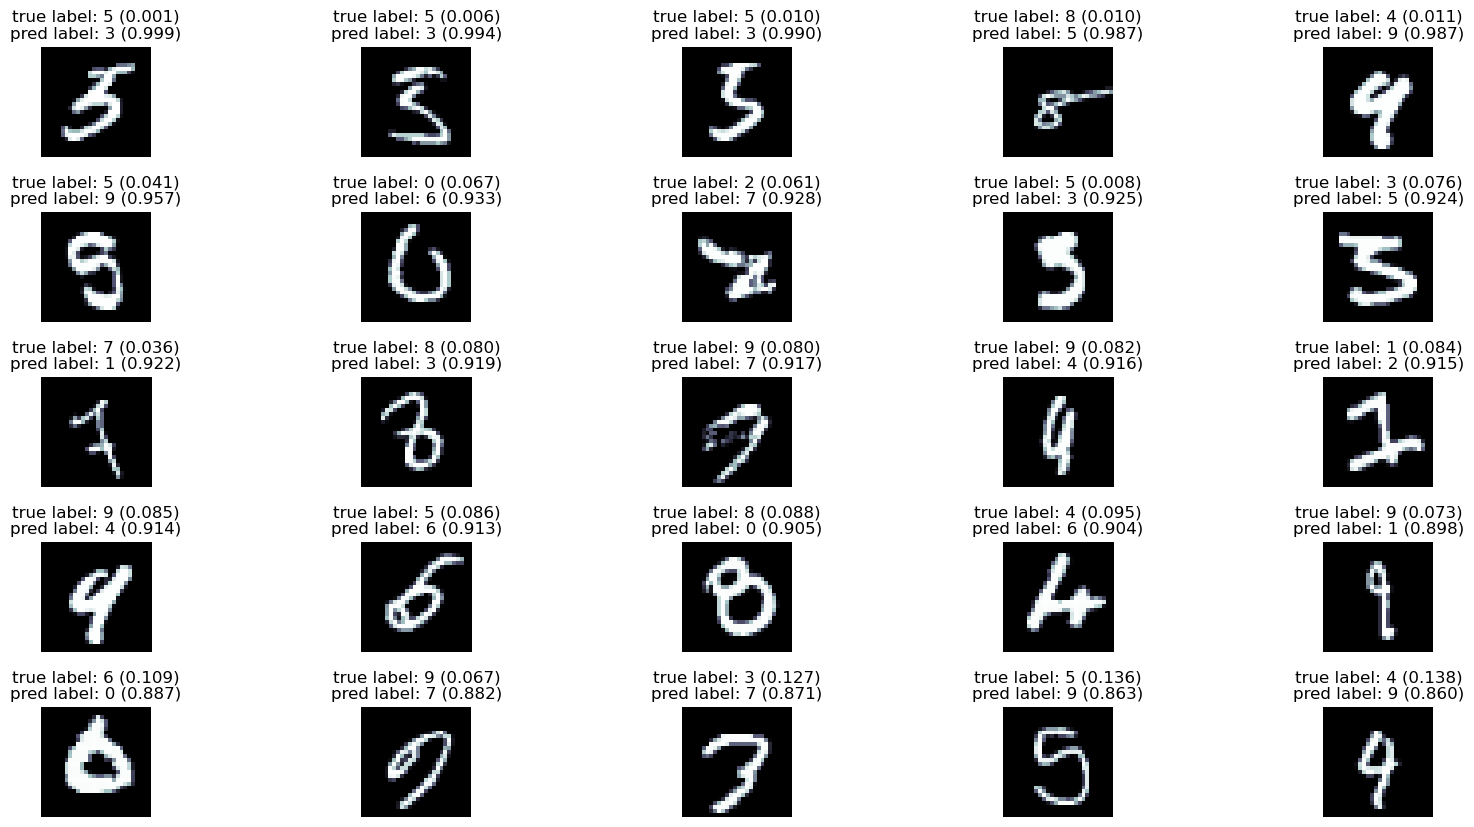

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Let's move on to plotting the model's representations in lower dimensions, so we can visualize them.

First, we'll get the representations from the model...

In [ ]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [ ]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

...and then calculate PCA on the representations.

In [ ]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

We then plot the PCA representations. 

Similar to the previous notebooks, even when the classes overlapped in the PCA representations, the confusion matrix showed that they weren't mixed up often at all.

In [ ]:
output_pca_data = get_pca(outputs)

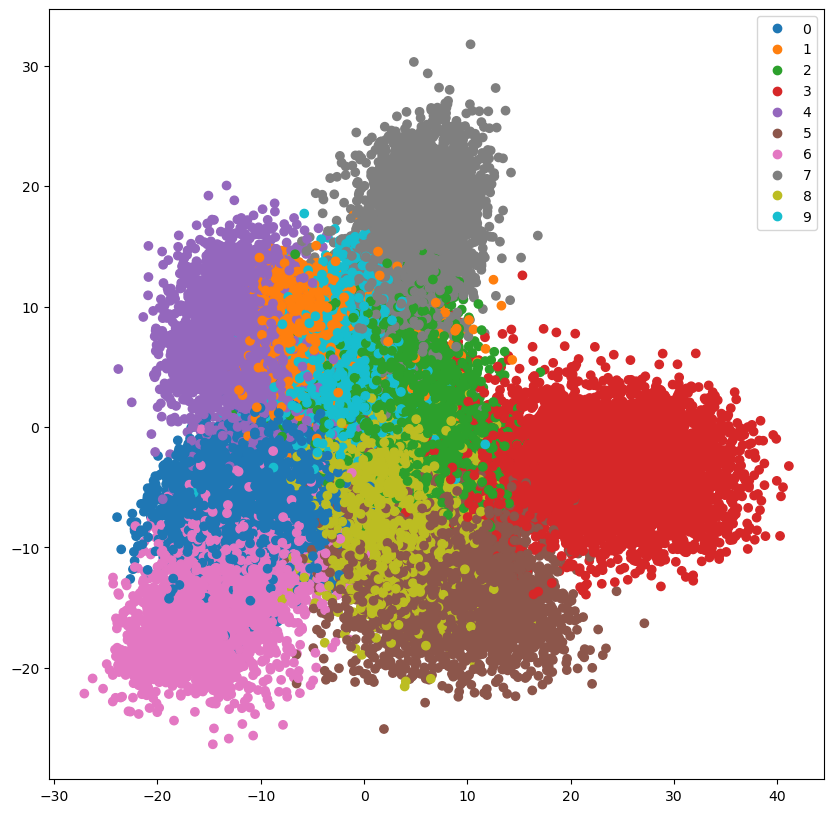

In [ ]:
plot_representations(output_pca_data, labels)

Plotting the PCA representations of the intermediate values, just after the second set of convolutional and subsampling layers.

We can see that a lot of the classes are overlapped in one giant cluster. Intuitively, this makes sense, as the model has only extracted the features of the image so far and not yet passed them to the linear layers that will weight these features to make an actual prediction.

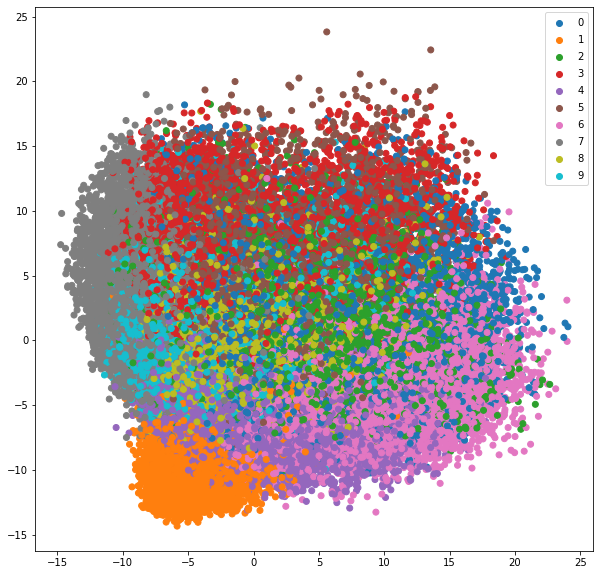

In [ ]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

We repeat the process for t-SNE. Again, we only use a subset of the data, as t-SNE takes a considerable amount of time.

In [ ]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

First, the output representations. t-SNE does a good job on separating out the classes.

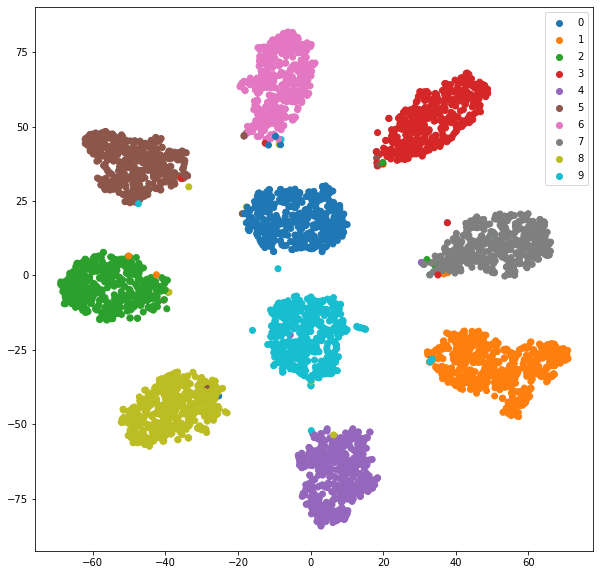

In [ ]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

Again, the intermediate representations are more clustered, which adds more evidence to the theory that this is just a representation of the extracted features before the linear layers have had a chance to weight up evidence on the presence or absence of certain extracted features.

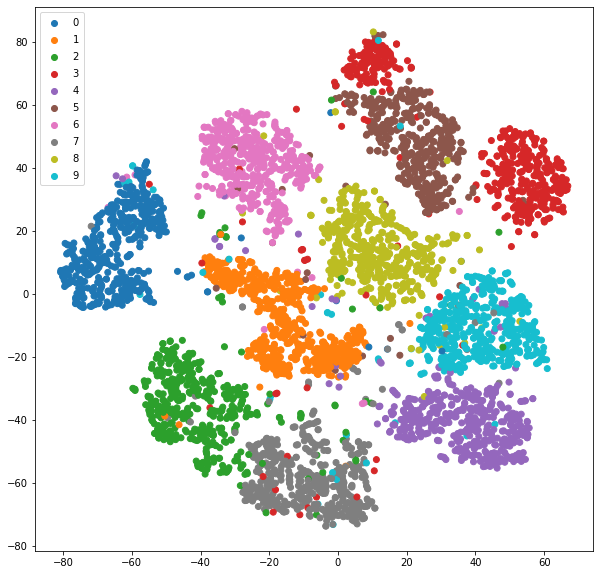

In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

As before, we can try generating a perfect handwritten digit by repeatedly generating a batch of noise and storing the noise that gave us the highest probability of being the digit we want. 

Surely as we now have convolutional layers that look for edges and curves we should get something more sensible, right?

In [ ]:
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 1, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

As we can see below, no. We get random noise with a >99% confidence that it's a three. 

Again, our model has been trained to be confident in its predictions and thus will be even for random noise. This is a flaw of neural networks and is a reason why [adversarial examples](https://openai.com/blog/adversarial-example-research/) work so well.

In [ ]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

In [ ]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 98.97%


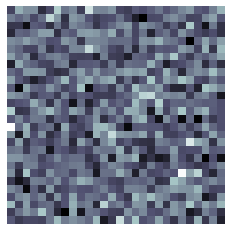

In [ ]:
plt.imshow(best_image.squeeze(0).cpu().numpy(), cmap='bone')
plt.axis('off');

Remember how we defined the Sobel filters early on in this tutorial? Well, as convolutional layers learn their own values for their filters, we can do the same thing and see how our filters process images.

Let's define a function that takes a batch of images and multiple filters, which it then uses on the images.

In [ ]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

Some of our filters look for areas of black pixels, which has the effect of inverting our images. Some apply a blur effect, which is similar to [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) effects used in image processing to reduce noise in the image. Some detect edges, like our Sobel filters we created earlier.

There is no guarantee each filter will learn a unique filtering effect. They are initialized randomly, and some filters may learn very similar weights. Therefore, it does not necessarily mean that using more filters will give a better performance.

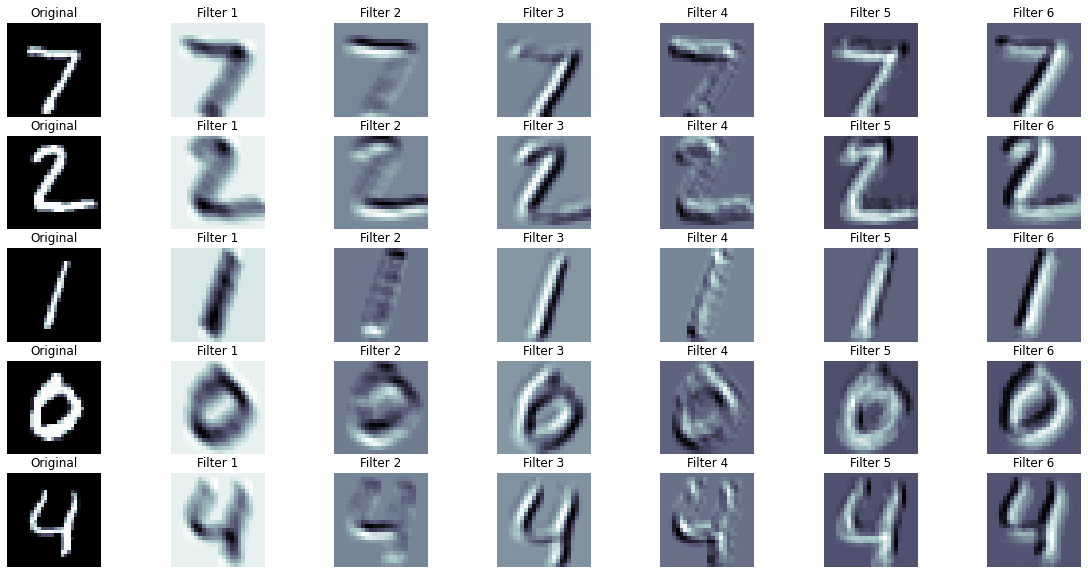

In [ ]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters)

Let's see what our best imagined digit looks like after passing through our filters. 

We get some nice looking patterns, but that's about it. 

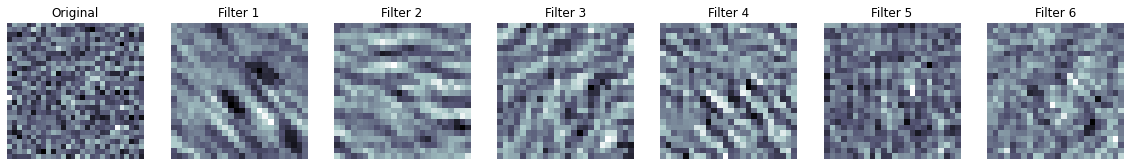

In [ ]:
plot_filtered_images([best_image], filters)

Finally, we'll plot the actual filters themselves.

In [ ]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):

        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filters[i].squeeze(0), cmap='bone')
        ax.axis('off')

There are some patterns visible, but it's difficult to interpret what these filters have actually learned.

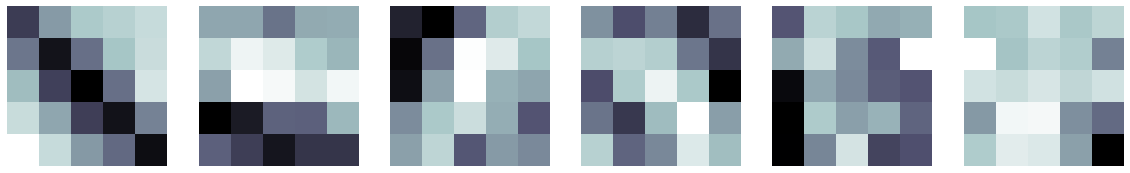

In [ ]:
plot_filters(filters)